# Applying Gumbel Softmax

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


## Settings

In [3]:
SAVE_NAME = 'vae.gumbel_softmax.t1e04'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'

TEST_SIZE = 1000
EPOCHS = 500
LR = 1e-04
BATCH_SIZE = 32
LABELS_FILE = '../scripts/pallets_labels.json'

TEMPERATURE = 0.0001


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
logger = L.init_logger(notebook=True)


## Load Environment

In [6]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../scripts/onehot_ds.pt')

dataset = torch.load('../scripts/onehot_ds.pt')

In [7]:
num_labels = len(dataset._labels[0])

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)



# The Model

This model builds off the VAE using in the previous notebook with a final call to gumbel-softmax, allow backprop to nudge the output of the decoder into place

In [8]:
class GumbelVAE(M.vae.LabeledVAE):
    def forward(self, x, labels):
        x = self.encode(x)

        x = torch.cat([x, labels], dim=1)
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        z = F.gumbel_softmax(z, tau=TEMPERATURE, hard=True)
        z = torch.cat([z, labels], dim=1)

        z = self.decode(z)

        return z, mu, logvar


# Train Model

latent_dims = 32
model = GumbelVAE(222, (64, 32), latent_dims, num_labels)

criterion = M.vae.Loss()


In [9]:
logger.info("starting model training")

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | starting model training
INFO | model: __main__.GumbelVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.0001
INFO | epochs: 500
INFO | epoch 1 (  0%) loss: 511222.500000
INFO | epoch 1 ( 35%) loss: 301098.999381
INFO | epoch 1 ( 70%) loss: 155598.726473
INFO | epoch 1 (100%) loss: 112621.618261
INFO | epoch 1 (test) loss: 5515.716793
INFO | epoch 2 (  0%) loss: 5639.371094
INFO | epoch 2 ( 35%) loss: 5493.391079
INFO | epoch 2 ( 70%) loss: 5358.391674
INFO | epoch 2 (100%) loss: 5266.014690
INFO | epoch 2 (test) loss: 4863.870888
INFO | epoch 3 (  0%) loss: 4903.822266
INFO | epoch 3 ( 35%) loss: 4925.490993
INFO | epoch 3 ( 70%) loss: 4849.989768
INFO | epoch 3 (100%) loss: 4773.906038
INFO | epoch 3 (test) loss: 4424.222878
INFO | epoch 4 (  0%) loss: 4526.819336
INFO | epoch 4 ( 35%) loss: 4437.252321
INFO | epoch 4 ( 70%) loss: 4336.563424
INFO | epoch 4 (100%) loss: 4221.812329
INFO | epoch 4 (test) loss: 3723.382881
INFO | epoch 5 (  0%) loss: 3848.466064
I

## Test Model

In [10]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


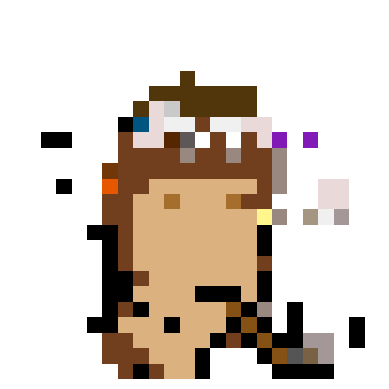

In [11]:

# Totally Random

z = torch.randn(1, latent_dims + num_labels).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


In [12]:
import json
ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

_, test_labels = next(iter(train_loader))
features = test_labels[2]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['female', 'halfShaved', 'classicShades']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


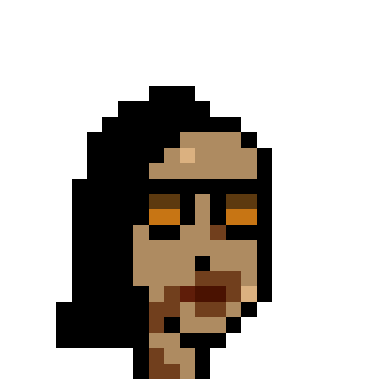

In [13]:
# Generate new image

# Random data for image side
z = torch.randn(1, latent_dims).to(device)

# Concat image with actual feature labels from dataset
z = torch.concat([z, features.unsqueeze(0)], dim=1)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)
decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Graph Losses

In [14]:
train_losses

[225243.2365220523,
 10532.029379986701,
 9547.812076649767,
 8443.624658895722,
 7069.596225170379,
 6529.986305182707,
 6304.774864250887,
 6138.933369954427,
 5997.33246931793,
 5865.160527222545,
 5736.967847025986,
 5590.292792570506,
 5443.940572535738,
 5306.240187191794,
 5180.517806682181,
 5060.276964119986,
 4937.624385319703,
 4815.444290918661,
 4693.8664148208945,
 4573.989159117354,
 4451.7859072854335,
 4331.219170320119,
 4215.049529379987,
 4111.241734714373,
 4022.387437752798,
 3951.2443929902206,
 3897.4675479104335,
 3845.153050848778,
 3804.2576677038314,
 3763.8393448633506,
 3729.8503939581256,
 3700.0229684816186,
 3670.999182734929,
 3630.890522625429,
 3593.331050142329,
 3563.77631697418,
 3535.5035023790724,
 3511.141332964525,
 3480.194196985123,
 3438.170505821282,
 3395.7944026432983,
 3364.754397561364,
 3341.867658466312,
 3326.269375199122,
 3310.478076042013,
 3293.96272937964,
 3281.7202081342116,
 3276.978165213943,
 3265.4610030803274,
 3262.9605

In [15]:
test_losses

[11031.433586120605,
 9727.741775512695,
 8848.445755004883,
 7446.765762329102,
 6501.790447235107,
 6222.919242858887,
 6035.662311553955,
 5892.304962158203,
 5758.278656005859,
 5633.126129150391,
 5498.264835357666,
 5358.855434417725,
 5209.782409667969,
 5080.77844619751,
 4955.929138183594,
 4838.527671813965,
 4729.720664978027,
 4608.65714263916,
 4488.219299316406,
 4370.028694152832,
 4254.964305877686,
 4139.22346496582,
 4020.675750732422,
 3928.899311065674,
 3850.3494091033936,
 3794.8752059936523,
 3758.106725692749,
 3697.368797302246,
 3660.6082878112793,
 3628.378469467163,
 3590.929208755493,
 3571.447385787964,
 3527.079978942871,
 3499.147554397583,
 3457.180751800537,
 3427.081600189209,
 3415.2604427337646,
 3383.4521522521973,
 3350.744354248047,
 3313.9523735046387,
 3270.36212348938,
 3250.816509246826,
 3228.272829055786,
 3207.770046234131,
 3217.5681705474854,
 3204.6456336975098,
 3171.811408996582,
 3163.032871246338,
 3158.472183227539,
 3153.895511627

<function matplotlib.pyplot.show(close=None, block=None)>

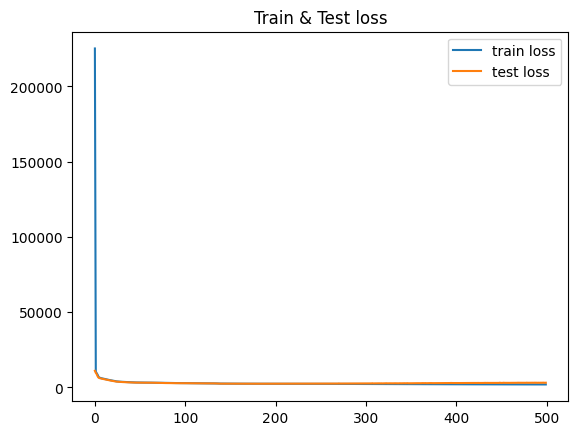

In [16]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
